In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, GroupKFold, ParameterGrid
from scipy.sparse import hstack
import xgboost as xgb
from xgboost.sklearn import XGBRanker
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('merged_df.csv')

In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-31 14:52:26 UTC,view,9001245,2053013553140465927,kids.toys,orange,9.24,516207684,43e06b30-9a10-4ac5-91dd-ff7ed04aab82
1,2019-10-23 12:09:33 UTC,view,2800436,2053013563835941749,appliances.kitchen.refrigerators,atlant,330.77,514498652,98c1ba90-5b20-4b48-ae64-e0223edc1627
2,2019-10-14 07:01:01 UTC,view,1004751,2053013555631882655,electronics.smartphone,samsung,196.83,528160375,29b1562d-8e2b-4298-ab2e-a186cbeaa7e1
3,2019-10-01 03:01:31 UTC,view,1004886,2053013555631882655,electronics.smartphone,oppo,153.04,525068636,03fdcfca-f8e1-40cf-928d-c104cf0de7ea
4,2019-10-14 10:23:01 UTC,view,1306183,2053013558920217191,computers.notebook,acer,360.34,538423585,efb58f80-2ca8-4489-b672-9dc7961eaa7a


In [4]:
df['event_type'].value_counts()

event_type
view        35929
cart         1480
purchase      999
Name: count, dtype: int64

In [5]:
df.head(), df.shape

(                event_time event_type  product_id          category_id  \
 0  2019-10-31 14:52:26 UTC       view     9001245  2053013553140465927   
 1  2019-10-23 12:09:33 UTC       view     2800436  2053013563835941749   
 2  2019-10-14 07:01:01 UTC       view     1004751  2053013555631882655   
 3  2019-10-01 03:01:31 UTC       view     1004886  2053013555631882655   
 4  2019-10-14 10:23:01 UTC       view     1306183  2053013558920217191   
 
                       category_code    brand   price    user_id  \
 0                         kids.toys   orange    9.24  516207684   
 1  appliances.kitchen.refrigerators   atlant  330.77  514498652   
 2            electronics.smartphone  samsung  196.83  528160375   
 3            electronics.smartphone     oppo  153.04  525068636   
 4                computers.notebook     acer  360.34  538423585   
 
                            user_session  
 0  43e06b30-9a10-4ac5-91dd-ff7ed04aab82  
 1  98c1ba90-5b20-4b48-ae64-e0223edc1627  
 2  29b15

In [6]:
df['user_id'].value_counts()

user_id
1515915625554995474    12
512475445               9
1515915625591659523     6
512505687               6
1515915625599852988     6
                       ..
1515915625521644898     1
1515915625515626372     1
1515915625539655009     1
1515915625526374669     1
514247883               1
Name: count, Length: 36926, dtype: int64

## Feature Engineering

In [7]:
#spliting the category code column values and storing the values in two new columns mainn_category and subcategory
df[['main_category','subcategory']]=df['category_code'].str.split('.', n=1, expand=True)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-31 14:52:26 UTC,view,9001245,2053013553140465927,kids.toys,orange,9.24,516207684,43e06b30-9a10-4ac5-91dd-ff7ed04aab82,kids,toys
1,2019-10-23 12:09:33 UTC,view,2800436,2053013563835941749,appliances.kitchen.refrigerators,atlant,330.77,514498652,98c1ba90-5b20-4b48-ae64-e0223edc1627,appliances,kitchen.refrigerators
2,2019-10-14 07:01:01 UTC,view,1004751,2053013555631882655,electronics.smartphone,samsung,196.83,528160375,29b1562d-8e2b-4298-ab2e-a186cbeaa7e1,electronics,smartphone
3,2019-10-01 03:01:31 UTC,view,1004886,2053013555631882655,electronics.smartphone,oppo,153.04,525068636,03fdcfca-f8e1-40cf-928d-c104cf0de7ea,electronics,smartphone
4,2019-10-14 10:23:01 UTC,view,1306183,2053013558920217191,computers.notebook,acer,360.34,538423585,efb58f80-2ca8-4489-b672-9dc7961eaa7a,computers,notebook


In [8]:
price=pd.DataFrame(df['price'])
type(price)

pandas.core.frame.DataFrame

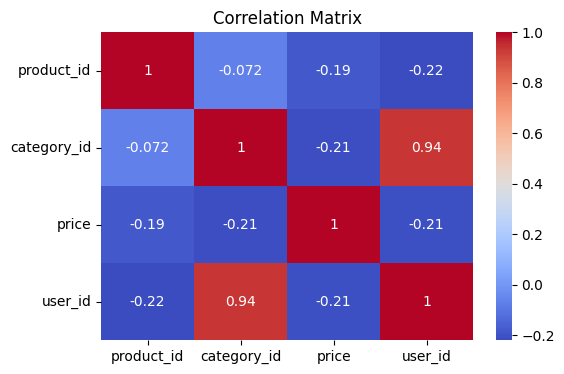

In [9]:
#correlation analysis
df_numeric=df.select_dtypes(include=np.number)
corr=df_numeric.corr(method='pearson')
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [10]:
#scaling the price column and creating a new price_scaled column
scaler=MinMaxScaler()
price=pd.DataFrame(df['price'])
df['price_scaled']=scaler.fit_transform(price)

In [11]:
interaction_map = {'view': 1, 'cart': 2, 'purchase': 3}
df['interaction_score'] = df['event_type'].map(interaction_map)

In [12]:
#combining all the categorical features into a single text for each instance
df['combined_text']=df['event_type'] + ' ' + df['category_code'] + ' ' + df['brand'] + ' ' + df['main_category'] + ' ' + df['subcategory'] 
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory,price_scaled,interaction_score,combined_text
0,2019-10-31 14:52:26 UTC,view,9001245,2053013553140465927,kids.toys,orange,9.24,516207684,43e06b30-9a10-4ac5-91dd-ff7ed04aab82,kids,toys,0.001556,1,view kids.toys orange kids toys
1,2019-10-23 12:09:33 UTC,view,2800436,2053013563835941749,appliances.kitchen.refrigerators,atlant,330.77,514498652,98c1ba90-5b20-4b48-ae64-e0223edc1627,appliances,kitchen.refrigerators,0.055713,1,view appliances.kitchen.refrigerators atlant a...
2,2019-10-14 07:01:01 UTC,view,1004751,2053013555631882655,electronics.smartphone,samsung,196.83,528160375,29b1562d-8e2b-4298-ab2e-a186cbeaa7e1,electronics,smartphone,0.033153,1,view electronics.smartphone samsung electronic...
3,2019-10-01 03:01:31 UTC,view,1004886,2053013555631882655,electronics.smartphone,oppo,153.04,525068636,03fdcfca-f8e1-40cf-928d-c104cf0de7ea,electronics,smartphone,0.025777,1,view electronics.smartphone oppo electronics s...
4,2019-10-14 10:23:01 UTC,view,1306183,2053013558920217191,computers.notebook,acer,360.34,538423585,efb58f80-2ca8-4489-b672-9dc7961eaa7a,computers,notebook,0.060694,1,view computers.notebook acer computers notebook


In [13]:
#dropping the columns price_scaled and category_id
df.drop(columns=['price', 'category_id'], inplace=True)
df.head()

,event_time,event_type,product_id,category_code,brand,user_id,user_session,main_category,subcategory,price_scaled,interaction_score,combined_text
0,2019-10-31 14:52:26 UTC,view,9001245,kids.toys,orange,516207684,43e06b30-9a10-4ac5-91dd-ff7ed04aab82,kids,toys,0.001556,1,view kids.toys orange kids toys
1,2019-10-23 12:09:33 UTC,view,2800436,appliances.kitchen.refrigerators,atlant,514498652,98c1ba90-5b20-4b48-ae64-e0223edc1627,appliances,kitchen.refrigerators,0.055713,1,view appliances.kitchen.refrigerators atlant a...
2,2019-10-14 07:01:01 UTC,view,1004751,electronics.smartphone,samsung,528160375,29b1562d-8e2b-4298-ab2e-a186cbeaa7e1,electronics,smartphone,0.033153,1,view electronics.smartphone samsung electronic...
3,2019-10-01 03:01:31 UTC,view,1004886,electronics.smartphone,oppo,525068636,03fdcfca-f8e1-40cf-928d-c104cf0de7ea,electronics,smartphone,0.025777,1,view electronics.smartphone oppo electronics s...
4,2019-10-14 10:23:01 UTC,view,1306183,computers.notebook,acer,538423585,efb58f80-2ca8-4489-b672-9dc7961eaa7a,computers,notebook,0.060694,1,view computers.notebook acer computers notebook


In [14]:
#implementing tfidf vectorizer on the combined text
tfidf_vectorizer=TfidfVectorizer(max_features=1200)
tfidf_matrix=tfidf_vectorizer.fit_transform(df['combined_text'])



In [15]:
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame for easier inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Display the first few rows of the TF-IDF matrix
print(tfidf_df.head())

   accessories  accord      acer  acme  acoustic  acqua  acv  adamex  adata  \
0          0.0     0.0  0.000000   0.0       0.0    0.0  0.0     0.0    0.0   
1          0.0     0.0  0.000000   0.0       0.0    0.0  0.0     0.0    0.0   
2          0.0     0.0  0.000000   0.0       0.0    0.0  0.0     0.0    0.0   
3          0.0     0.0  0.000000   0.0       0.0    0.0  0.0     0.0    0.0   
4          0.0     0.0  0.469178   0.0       0.0    0.0  0.0     0.0    0.0   

   adidas  ...  zalman  zanussi  zebra  zelmer  zeppelin  zeta  zinc  zlatek  \
0     0.0  ...     0.0      0.0    0.0     0.0       0.0   0.0   0.0     0.0   
1     0.0  ...     0.0      0.0    0.0     0.0       0.0   0.0   0.0     0.0   
2     0.0  ...     0.0      0.0    0.0     0.0       0.0   0.0   0.0     0.0   
3     0.0  ...     0.0      0.0    0.0     0.0       0.0   0.0   0.0     0.0   
4     0.0  ...     0.0      0.0    0.0     0.0       0.0   0.0   0.0     0.0   

   zte  zyxel  
0  0.0    0.0  
1  0.0    0.

In [16]:
#combining the tfidf_matrix with the numerical feature column prices_scaled

#preparing the price_scaled column by converting it into a 2D array
price_features=df['price_scaled'].values.reshape(-1,1)

#combining the features using sparse matrices
combined_features=hstack([tfidf_matrix, price_features])

print(f'Final feature matrix shape: {combined_features.shape}')

Final feature matrix shape: (38408, 1201)


In [17]:
# #compute cosine similarities
# sparse_features = csr_matrix(combined_features)

# item_similarity=cosine_similarity(sparse_features, dense_output=False)



In [18]:
sparse_features = csr_matrix(combined_features)

def compute_top_k_similarities(features, batch_size=1000, top_k=10):
    n_samples = features.shape[0]
    
    # Store only the top-k similarities per row
    top_k_indices = np.zeros((n_samples, top_k), dtype=int)
    top_k_values = np.zeros((n_samples, top_k), dtype=float)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        # Compute similarity only for the batch
        batch_similarities = cosine_similarity(features[start:end], features, dense_output=False)

        # Convert sparse matrix to dense for indexing 
        batch_similarities = batch_similarities.toarray()

        # Get top-k values and indices
        for i in range(batch_similarities.shape[0]):
            row = batch_similarities[i]
            top_k_idx = np.argpartition(row, -top_k)[-top_k:]  # Get indices of top-k
            sorted_idx = top_k_idx[np.argsort(-row[top_k_idx])]  # Sort them
            top_k_indices[start + i] = sorted_idx
            top_k_values[start + i] = row[sorted_idx]
    
    return top_k_indices, top_k_values

# Run with sparse features
top_k_indices, top_k_values = compute_top_k_similarities(sparse_features)

In [19]:
import numpy as np

# Filter interactions based on event_type (e.g., 'view', 'purchase')
user_interactions = df[df['event_type'].isin(['view', 'purchase'])]

# Group by user_id and aggregate product features
user_profiles = {}
for user_id, group in user_interactions.groupby('user_id'):
    # Get indices of products interacted by the user
    product_indices = group.index
    
    # Aggregate TF-IDF features for these products
    aggregated_tfidf = np.mean(tfidf_matrix[product_indices].toarray(), axis=0)
    
    # Aggregate numerical feature (price_scaled)
    aggregated_price = np.mean(group['price_scaled'])
    
    # Combine aggregated TF-IDF and price into a single profile vector
    user_profile = np.hstack([aggregated_tfidf, aggregated_price])
    
    # Store the user profile
    user_profiles[user_id] = user_profile

print(f"Number of user profiles created: {len(user_profiles)}")


Number of user profiles created: 35601


In [20]:
from sklearn.metrics import precision_score, ndcg_score
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity

def recommend_and_evaluate_tfidf(user_id, data, user_profiles, combined_features, k=5):
    """
    Recommend and evaluate top K products for a user using TF-IDF similarity.
    
    Args:
        user_id (int): ID of the user.
        data (pd.DataFrame): Dataset with user interactions.
        user_profiles (dict): Precomputed user profiles (TF-IDF + price_scaled).
        combined_features (sparse matrix): Combined TF-IDF and price_scaled matrix.
        k (int): Number of recommendations.
    
    Returns:
        dict: Recommendations and evaluation metrics.
    """
    if user_id not in user_profiles:
        return {"error": f"No profile found for user {user_id}"}
    
    # Get the user's profile vector
    user_profile_vector = user_profiles[user_id]
    
    # Compute similarity between user's profile and all product vectors
    product_similarity_scores = cosine_similarity([user_profile_vector], combined_features.toarray())[0]
    
    # Get indices of top K similar products
    user_indices = data[data['user_id'] == user_id].index.values
    top_indices = [idx for idx in np.argsort(product_similarity_scores)[::-1] if idx not in user_indices][:k]
    
    # Get recommended products
    recommendations = data.iloc[top_indices][['product_id', 'brand', 'subcategory']].copy()
    recommendations['similarity_score'] = product_similarity_scores[top_indices]
    
    # Ground truth interaction scores for recommended products
    user_data = data[data['user_id'] == user_id]
    true_scores = [user_data[user_data['product_id'] == pid]['interaction_score'].iloc[0] 
                   if pid in user_data['product_id'].values else 0 for pid in recommendations['product_id']]
    
    # Binary relevance (relevant if interaction_score >= 2, i.e., cart or purchase)
    binary_true = np.array([1 if score >= 2 else 0 for score in true_scores])
    
    # Compute metrics
    precision = precision_score(binary_true, binary_true * 0 + 1, zero_division=0)  # Simplified, adjust if needed
    all_true_scores = user_data['interaction_score'].values
    all_pred_scores = product_similarity_scores[user_indices]
    ndcg = ndcg_score([all_true_scores], [all_pred_scores], k=k) if len(all_true_scores) > 1 else 0
    
    return {
        "recommendations": recommendations,
        "precision@k": precision,
        "ndcg@k": ndcg,
        "true_scores": true_scores,
        "predicted_scores": recommendations['similarity_score'].values
    }

user_id_to_recommend = 516207684  
result = recommend_and_evaluate_tfidf(user_id_to_recommend, df, user_profiles, combined_features, k=5)
if "error" not in result:
    print("TF-IDF Recommendations:\n", result["recommendations"])
    print(f"Precision@5: {result['precision@k']:.3f}")
    print(f"NDCG@5: {result['ndcg@k']:.3f}")

TF-IDF Recommendations:
        product_id   brand subcategory  similarity_score
13670     9001506  orange        toys          1.000000
2712      9000564  orange        toys          1.000000
11203     9000564  orange        toys          1.000000
15207     9001886  orange        toys          0.999999
26180     9001886  orange        toys          0.999999
Precision@5: 0.000
NDCG@5: 0.000


In [21]:
# def recommend_to_user(user_id, num_recommendations=5):
#     if user_id not in user_profiles:
#         return f"No profile found for user {user_id}."
    
#     # Get the user's profile vector
#     user_profile_vector = user_profiles[user_id]
    
#     # Compute similarity between user's profile and all product vectors
#     product_similarity_scores = cosine_similarity([user_profile_vector], combined_features.toarray())[0]
    
#     # Get indices of top similar products
#     top_indices = np.argsort(product_similarity_scores)[::-1][:num_recommendations]
    
#     # Get product IDs for recommended products
#     recommended_products = df.iloc[top_indices][['product_id', 'brand', 'subcategory']]
    
#     return recommended_products

# # Example usage
# user_id_to_recommend = 541992474  # Replace with an actual user ID from your data
# recommended_products_for_user = recommend_to_user(user_id_to_recommend)
# # print(f"Recommended products for user {user_id_to_recommend}: {recommended_products_for_user}")
# # print(f"Recommended products for user {user_id_to_recommend}: {recommended_products_for_user}")
# recommended_products_for_user

## XGBoost

In [22]:
df2=pd.read_csv('merged_df.csv')

In [23]:
df2.head(),df2.shape

(                event_time event_type  product_id          category_id  \
 0  2019-10-31 14:52:26 UTC       view     9001245  2053013553140465927   
 1  2019-10-23 12:09:33 UTC       view     2800436  2053013563835941749   
 2  2019-10-14 07:01:01 UTC       view     1004751  2053013555631882655   
 3  2019-10-01 03:01:31 UTC       view     1004886  2053013555631882655   
 4  2019-10-14 10:23:01 UTC       view     1306183  2053013558920217191   
 
                       category_code    brand   price    user_id  \
 0                         kids.toys   orange    9.24  516207684   
 1  appliances.kitchen.refrigerators   atlant  330.77  514498652   
 2            electronics.smartphone  samsung  196.83  528160375   
 3            electronics.smartphone     oppo  153.04  525068636   
 4                computers.notebook     acer  360.34  538423585   
 
                            user_session  
 0  43e06b30-9a10-4ac5-91dd-ff7ed04aab82  
 1  98c1ba90-5b20-4b48-ae64-e0223edc1627  
 2  29b15

In [24]:
interaction_map = {'view': 1, 'cart': 2, 'purchase': 3}
df2['interaction_score'] = df2['event_type'].map(interaction_map)

In [25]:
user_product_stats = df2.groupby(['user_id', 'product_id']).agg(
    total_interactions=('interaction_score', 'count'),
    avg_interaction_score=('interaction_score', 'mean'),
    last_interaction_score=('interaction_score', 'last')
).reset_index()

# Merge back with original data
df2 = df2.merge(user_product_stats, on=['user_id', 'product_id'], how='left')

In [26]:
#encoding the categorical variables
label_enc = LabelEncoder()
df2['brand'] = label_enc.fit_transform(df2['brand'])
df2['category_code'] = label_enc.fit_transform(df2['category_code'])


In [27]:
# Features for ranking
X = df2[['user_id', 'product_id', 'category_code', 'brand', 'price', 
        'total_interactions', 'avg_interaction_score', 'last_interaction_score']]
y = df2['interaction_score']  # Target is the interaction score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate group sizes for test set
group_test = X_test.groupby('user_id').size().to_numpy()

In [28]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
}

# Use GroupKFold for cross-validation
gkf = GroupKFold(n_splits=5)

# Manual cross-validation
best_score = float('inf')
best_params = None
X_train_features = X_train.drop(columns=['user_id', 'product_id'])

for params in ParameterGrid(param_grid):
    scores = []
    for train_idx, val_idx in gkf.split(X_train_features, y_train, groups=X_train['user_id']):
        # Split data for this fold
        X_tr, X_val = X_train_features.iloc[train_idx], X_train_features.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Calculate group sizes for this fold
        group_tr = X_train.iloc[train_idx].groupby('user_id').size().to_numpy()
        
        # Train the model
        model = xgb.XGBRanker(**params, objective='rank:pairwise', random_state=42)
        model.fit(X_tr, y_tr, group=group_tr)
        
        # Predict and evaluate
        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        scores.append(mse)
    
    # Average score across folds
    avg_score = np.mean(scores)
    print(f"Params: {params}, Avg MSE: {avg_score}")
    if avg_score < best_score:
        best_score = avg_score
        best_params = params

print("Best Parameters:", best_params, "Best MSE:", best_score)

Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}, Avg MSE: 2.1441203594207763
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}, Avg MSE: 3.025545930862427
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}, Avg MSE: 2.1434604644775392
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}, Avg MSE: 3.0230700969696045
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}, Avg MSE: 10.617846298217774
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}, Avg MSE: 11.191568565368652
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}, Avg MSE: 10.525036811828613
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, Avg MSE: 11.062234497070312
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50} Best MSE: 2.1434604644775392


In [29]:
best_model = xgb.XGBRanker(**best_params, objective='rank:pairwise', random_state=42)
group_train = X_train.groupby('user_id').size().to_numpy()
best_model.fit(X_train_features, y_train, group=group_train)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=0.01, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [30]:
df2.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,interaction_score,total_interactions,avg_interaction_score,last_interaction_score
0,2019-10-31 14:52:26 UTC,view,9001245,2053013553140465927,138,668,9.24,516207684,43e06b30-9a10-4ac5-91dd-ff7ed04aab82,1,1,1.0,1
1,2019-10-23 12:09:33 UTC,view,2800436,2053013563835941749,42,71,330.77,514498652,98c1ba90-5b20-4b48-ae64-e0223edc1627,1,1,1.0,1
2,2019-10-14 07:01:01 UTC,view,1004751,2053013555631882655,114,801,196.83,528160375,29b1562d-8e2b-4298-ab2e-a186cbeaa7e1,1,1,1.0,1
3,2019-10-01 03:01:31 UTC,view,1004886,2053013555631882655,114,665,153.04,525068636,03fdcfca-f8e1-40cf-928d-c104cf0de7ea,1,1,1.0,1
4,2019-10-14 10:23:01 UTC,view,1306183,2053013558920217191,75,1,360.34,538423585,efb58f80-2ca8-4489-b672-9dc7961eaa7a,1,1,1.0,1


In [31]:
from sklearn.metrics import precision_score, ndcg_score
import numpy as np
import pandas as pd

def recommend_and_evaluate_xgboost(user_id, data, model, product_info, label_encoder, y_train, k=5):
    """
    Recommend and evaluate top K products for a user using XGBRanker on training data.
    
    Args:
        user_id (int): ID of the user.
        data (pd.DataFrame): Training dataset containing user and product features (e.g., X_train).
        model (XGBRanker): Trained XGBRanker model.
        product_info (pd.DataFrame): Dataset containing product_id and additional info like category_code.
        label_encoder (LabelEncoder): The LabelEncoder object used to encode category_code.
        y_train (pd.Series): Ground truth interaction scores corresponding to data.
        k (int): Number of recommendations to evaluate.
    
    Returns:
        dict: Recommendations and evaluation metrics.
    """
    # Filter data for the given user
    user_data = data[data['user_id'] == user_id].copy()  # Use .copy() to avoid SettingWithCopyWarning
    
    if user_data.empty:
        return {"error": f"No data available for user {user_id}"}
    
    # Add interaction_score from y_train to user_data
    user_data['interaction_score'] = y_train.loc[user_data.index]
    
    # Prepare input features (drop user_id, product_id, and interaction_score)
    features = user_data.drop(columns=['user_id', 'product_id', 'interaction_score'])
    
    # Predict interaction scores
    user_data['predicted_score'] = model.predict(features)
    
    # Ground truth interaction scores
    true_scores = user_data['interaction_score'].values
    
    # Sort by predicted score in descending order
    recommendations = user_data.sort_values(by='predicted_score', ascending=False)
    
    # Select top K products
    top_k = recommendations[['product_id', 'predicted_score']].head(k)
    
    # Deduplicate product_info to ensure unique product_id
    unique_product_info = product_info[['product_id', 'category_code']].drop_duplicates(subset='product_id')
    
    # Map the encoded category_code values
    top_k['product_name_encoded'] = top_k['product_id'].map(unique_product_info.set_index('product_id')['category_code'])
    
    # Decode the category_code back to original strings
    top_k['product_name'] = label_encoder.inverse_transform(top_k['product_name_encoded'].astype(int))
    
    # Drop the temporary encoded column
    top_k = top_k.drop(columns=['product_name_encoded'])
    
    # True relevance scores for top K
    top_k_true_scores = recommendations['interaction_score'].head(k).values
    
    # Binary relevance (relevant if interaction_score >= 2, i.e., cart or purchase)
    binary_true = np.array([1 if score >= 2 else 0 for score in top_k_true_scores])
    
    # Compute metrics
    precision = precision_score(binary_true, binary_true * 0 + 1, zero_division=0)  # Simplified, see note
    ndcg = ndcg_score([true_scores], [user_data['predicted_score'].values], k=k) if len(true_scores) > 1 else 0
    
    return {
        "recommendations": top_k,
        "precision@k": precision,
        "ndcg@k": ndcg,
        "true_scores": top_k_true_scores,
        "predicted_scores": top_k['predicted_score'].values
    }

user_id_to_recommend = 516207684  
result = recommend_and_evaluate_xgboost(user_id_to_recommend, X_train, best_model, df2, label_enc, y_train, k=5)
if "error" not in result:
    print("XGBRanker Recommendations (Training Set):\n", result["recommendations"])
    print(f"Precision@5: {result['precision@k']:.3f}")
    print(f"NDCG@5: {result['ndcg@k']:.3f}")
else:
    print(result["error"])

XGBRanker Recommendations (Training Set):
    product_id  predicted_score product_name
0     9001245        -0.414667    kids.toys
Precision@5: 0.000
NDCG@5: 0.000


## Random Forest

In [32]:
df1=pd.read_csv('merged_df.csv')

In [33]:
df1.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-31 14:52:26 UTC,view,9001245,2053013553140465927,kids.toys,orange,9.24,516207684,43e06b30-9a10-4ac5-91dd-ff7ed04aab82
1,2019-10-23 12:09:33 UTC,view,2800436,2053013563835941749,appliances.kitchen.refrigerators,atlant,330.77,514498652,98c1ba90-5b20-4b48-ae64-e0223edc1627
2,2019-10-14 07:01:01 UTC,view,1004751,2053013555631882655,electronics.smartphone,samsung,196.83,528160375,29b1562d-8e2b-4298-ab2e-a186cbeaa7e1
3,2019-10-01 03:01:31 UTC,view,1004886,2053013555631882655,electronics.smartphone,oppo,153.04,525068636,03fdcfca-f8e1-40cf-928d-c104cf0de7ea
4,2019-10-14 10:23:01 UTC,view,1306183,2053013558920217191,computers.notebook,acer,360.34,538423585,efb58f80-2ca8-4489-b672-9dc7961eaa7a


In [34]:
interaction_map = {'view': 1, 'cart': 2, 'purchase': 3}
df1['interaction_score'] = df1['event_type'].map(interaction_map)

# User-product stats
user_product_stats = df1.groupby(['user_id', 'product_id']).agg(
    total_interactions=('interaction_score', 'count'),
    avg_interaction_score=('interaction_score', 'mean'),
    last_interaction_score=('interaction_score', 'last')
).reset_index()

df1 = df1.merge(user_product_stats, on=['user_id', 'product_id'], how='left')

# Encode categorical variables
label_enc = LabelEncoder()
df1['brand'] = label_enc.fit_transform(df1['brand'])
df1['category_code'] = label_enc.fit_transform(df1['category_code'])

# Define features and target
features = ['category_code', 'brand', 'price', 'total_interactions', 'avg_interaction_score', 'last_interaction_score']
X = df1[['user_id', 'product_id'] + features]  # Include user_id and product_id for filtering
y = df1['interaction_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model (no hyperparameter tuning)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train[features], y_train)

RandomForestRegressor(random_state=42)

In [35]:
def recommend_and_evaluate_rf(user_id, data, model, product_info, label_encoder, y_train, k=5):
    """
    Recommend and evaluate top K products for a user using Random Forest on training data.
    
    Args:
        user_id (int): ID of the user.
        data (pd.DataFrame): Training dataset containing user and product features (e.g., X_train).
        model (RandomForestRegressor): Trained Random Forest model.
        product_info (pd.DataFrame): Dataset containing product_id and additional info like category_code.
        label_encoder (LabelEncoder): The LabelEncoder object used to encode category_code.
        y_train (pd.Series): Ground truth interaction scores corresponding to data.
        k (int): Number of recommendations to evaluate.
    
    Returns:
        dict: Recommendations and evaluation metrics.
    """
    # Filter data for the given user
    user_data = data[data['user_id'] == user_id].copy()
    
    if user_data.empty:
        return {"error": f"No data available for user {user_id}"}
    
    # Add interaction_score from y_train to user_data
    user_data['interaction_score'] = y_train.loc[user_data.index]
    
    # Prepare input features (drop user_id, product_id, and interaction_score)
    features = user_data.drop(columns=['user_id', 'product_id', 'interaction_score'])
    
    # Predict interaction scores
    user_data['predicted_score'] = model.predict(features)
    
    # Ground truth interaction scores
    true_scores = user_data['interaction_score'].values
    
    # Sort by predicted score in descending order
    recommendations = user_data.sort_values(by='predicted_score', ascending=False)
    
    # Select top K products
    top_k = recommendations[['product_id', 'predicted_score']].head(k)
    
    # Deduplicate product_info to ensure unique product_id
    unique_product_info = product_info[['product_id', 'category_code']].drop_duplicates(subset='product_id')
    
    # Map the encoded category_code values
    top_k['product_name_encoded'] = top_k['product_id'].map(unique_product_info.set_index('product_id')['category_code'])
    
    # Decode the category_code back to original strings
    top_k['product_name'] = label_encoder.inverse_transform(top_k['product_name_encoded'].astype(int))
    
    # Drop the temporary encoded column
    top_k = top_k.drop(columns=['product_name_encoded'])
    
    # True relevance scores for top K
    top_k_true_scores = recommendations['interaction_score'].head(k).values
    
    # Binary relevance (relevant if interaction_score >= 2, i.e., cart or purchase)
    binary_true = np.array([1 if score >= 2 else 0 for score in top_k_true_scores])
    
    # Compute metrics
    precision = precision_score(binary_true, binary_true * 0 + 1, zero_division=0)  # Simplified, see note
    ndcg = ndcg_score([true_scores], [user_data['predicted_score'].values], k=k) if len(true_scores) > 1 else 0
    
    return {
        "recommendations": top_k,
        "precision@k": precision,
        "ndcg@k": ndcg,
        "true_scores": top_k_true_scores,
        "predicted_scores": top_k['predicted_score'].values
    }

# Example usage with training set
user_id_to_recommend = 528160375  
result = recommend_and_evaluate_rf(user_id_to_recommend, X_train, rf_model, df1, label_enc, y_train, k=5)
if "error" not in result:
    print("Random Forest Recommendations (Training Set):\n", result["recommendations"])
    print(f"Precision@5: {result['precision@k']:.3f}")
    print(f"NDCG@5: {result['ndcg@k']:.3f}")
else:
    print(result["error"])

Random Forest Recommendations (Training Set):
    product_id  predicted_score            product_name
2     1004751              1.0  electronics.smartphone
Precision@5: 0.000
NDCG@5: 0.000


In [37]:
def compare_recommendations(user_id, tfidf_data, user_profiles, combined_features, 
                          xgb_data, xgb_model, rf_data, rf_model, product_info, 
                          label_encoder, y_train, k=5):
    """
    Compare recommendations from TF-IDF, XGBRanker, and Random Forest for a given user.
    
    Args:
        user_id (int): ID of the user.
        tfidf_data (pd.DataFrame): Dataset for TF-IDF (with interaction_score).
        user_profiles (dict): Precomputed TF-IDF user profiles.
        combined_features (sparse matrix): TF-IDF + price_scaled matrix.
        xgb_data (pd.DataFrame): Dataset for XGBRanker (e.g., X_train).
        xgb_model (XGBRanker): Trained XGBRanker model.
        rf_data (pd.DataFrame): Dataset for Random Forest (e.g., X_train).
        rf_model (RandomForestRegressor): Trained Random Forest model.
        product_info (pd.DataFrame): Dataset with product_id and category_code.
        label_encoder (LabelEncoder): Encoder for category_code.
        y_train (pd.Series): Ground truth interaction scores.
        k (int): Number of recommendations.
    
    Returns:
        dict: Results from all three approaches.
    """
    # TF-IDF Recommendations
    tfidf_result = recommend_and_evaluate_tfidf(user_id, tfidf_data, user_profiles, combined_features, k)
    if "error" not in tfidf_result:
        print("TF-IDF Recommendations:\n", tfidf_result["recommendations"])
        print(f"Precision@5: {tfidf_result['precision@k']:.3f}")
        print(f"NDCG@5: {tfidf_result['ndcg@k']:.3f}\n")
    else:
        print("TF-IDF:", tfidf_result["error"], "\n")

    # Create a copy of product_info with encoded category_code for XGBRanker and Random Forest
    product_info_encoded = product_info.copy()
    product_info_encoded['category_code'] = label_encoder.transform(product_info_encoded['category_code'])

    # XGBRanker Recommendations
    xgb_result = recommend_and_evaluate_xgboost(user_id, xgb_data, xgb_model, product_info_encoded, label_encoder, y_train, k)
    if "error" not in xgb_result:
        print("XGBRanker Recommendations (Training Set):\n", xgb_result["recommendations"])
        print(f"Precision@5: {xgb_result['precision@k']:.3f}")
        print(f"NDCG@5: {xgb_result['ndcg@k']:.3f}\n")
    else:
        print("XGBRanker:", xgb_result["error"], "\n")

    # Random Forest Recommendations
    rf_result = recommend_and_evaluate_rf(user_id, rf_data, rf_model, product_info_encoded, label_encoder, y_train, k)
    if "error" not in rf_result:
        print("Random Forest Recommendations (Training Set):\n", rf_result["recommendations"])
        print(f"Precision@5: {rf_result['precision@k']:.3f}")
        print(f"NDCG@5: {rf_result['ndcg@k']:.3f}\n")
    else:
        print("Random Forest:", rf_result["error"], "\n")

    return {
        "tfidf": tfidf_result,
        "xgboost": xgb_result,
        "random_forest": rf_result
    }

# Example usage
user_id_to_compare = 516207684
results = compare_recommendations(user_id_to_compare, df, user_profiles, combined_features, 
                                X_train, best_model, X_train, rf_model, df, label_enc, y_train, k=5)

TF-IDF Recommendations:
        product_id   brand subcategory  similarity_score
13670     9001506  orange        toys          1.000000
2712      9000564  orange        toys          1.000000
11203     9000564  orange        toys          1.000000
15207     9001886  orange        toys          0.999999
26180     9001886  orange        toys          0.999999
Precision@5: 0.000
NDCG@5: 0.000

XGBRanker Recommendations (Training Set):
    product_id  predicted_score product_name
0     9001245        -0.414667    kids.toys
Precision@5: 0.000
NDCG@5: 0.000

Random Forest Recommendations (Training Set):
    product_id  predicted_score product_name
0     9001245              1.0    kids.toys
Precision@5: 0.000
NDCG@5: 0.000

